# Double Pendulum Final (Lagrangian)
* Last revised 04-29-2023 by Aaron Woyshville (woyshville.1@osu.edu).

A Jupyter notebook that solves for and plots the angles for the Double Pendulum using the Euler-Lagrange method.

Here, a pendulum is considered as a rigid but massless rod of length L with a bob of mass m attached at the end. A double pendulum attaches a second pendulum to the bob of the first.

The double pendulum is used as a simple demonstration of chaotic motion.

Below is an image from the Wikipedia article on the double pendulum. It will be used as a reference for the variables defined in this notebook: rod lengths $L_1$ and $L_2$, masses $m_1$ and $m_2$, and angles (from vertical) $\theta_1$ and $\theta_2$.

In [1]:
from IPython.display import Image

Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

The generalized coordinates used will be $\theta_1$ and $\theta_2$. In cartesian coordinates, the position and velocities of the masses are:
<br /><br />
$x_1=L_1\sin\theta_1\qquad\qquad\qquad\qquad
y_1=L_1\cos\theta_1\\
\dot x_1=L_1\dot\theta_1\cos\theta_1\qquad\qquad\qquad\quad
\dot y_1=-L_1\dot\theta_1\sin\theta_1
\\
x_2=x_1+L_2\sin\theta_2\qquad\qquad\qquad
y_2=y_1+L_2\cos\theta_2
\\
\dot x_2=L_1\dot\theta_1\cos\theta_1+L_2\dot\theta_2\cos\theta_2\qquad
\dot y_2=-L_1\dot\theta_1\sin\theta_1-L_2\dot\theta_2\sin\theta_2$
<br />
In terms of the generalized coordinates $\theta_1$ and $\theta_2$, the Kinetic Energy $T$ and Potential Energy $U$ expressions are:
<br /><br />
$T=\frac12m_1L_1^2\dot\theta_1^2+\frac12m_2[L_1^2\dot\theta_1^2+L_2^2\dot\theta_2^2+2L_1L_2\cos(\theta_1-\theta_2)\dot\theta_1\dot\theta_2]$
<br /><br />
$U=-(m_1+m_2)L_1g\cos\theta_1-m_2L_2g\cos\theta_2$
<br /><br />
And the expression for the Lagrangian $\mathcal{L} = T - U$:<br /><br />
$\mathcal{L}=\frac12(m_1+m_2)L_1^2\dot\theta_1^2+\frac12m_2L_2^2\dot\theta_2^2+m_2L_1L_2\dot\theta_1\dot\theta_2\cos(\theta_1-\theta_2)+(m_1+m_2)L_1g\cos\theta_1+m_2gL_2\cos\theta_2$.<br /><br />
The Euler-Lagrange equations are:<br /><br />
$\large\frac{d}{dt}(\frac{\partial\mathcal{L}}{\partial\dot q_i}) \normalsize- \large\frac{\partial\mathcal{L}}{\partial q_i} \normalsize = 0$, for $q_i=\theta_1,\theta_2$<br /><br />
Solving to find expressions for $\ddot\theta_1$ and $\ddot\theta_2$ yields:<br /><br />
$(m_1+m_2)L_1\ddot\theta_1+m_2L_2\ddot\theta_2\cos(\theta_1-\theta_2)+m_2L_2\dot\theta_2^2\sin(\theta_1-\theta_2)+(m_1+m_2)g\sin\theta_1=0,$<br />
$m_2L_2\ddot\theta_2+m_2L_1\ddot\theta_1\cos(\theta_1-\theta_2)-m_2L_1\dot\theta_1^2\sin(\theta_1-\theta_2)+m_2g\sin\theta_2=0.$<br /><br />
Lastly, the above expressions are second-order differential equations. Since integrate.solve_ivp works with first-order differential equations, we will let $z_1\equiv\dot\theta_1\Rightarrow\ddot\theta_1=\dot z_1$ and $z_2\equiv\dot\theta_2\Rightarrow\ddot\theta_2=\dot z_2$, and rearrange to obtain and code the following expressions:<br /><br />
$\dot z_1 = \large\frac{m_2g\sin\theta_2\cos(\theta_1-\theta_2)-m_2\sin(\theta_1-\theta_2)[L_1z_1^2\cos(\theta_1-\theta_2)+L_2z_2^2]-(m_1+m_2)g\sin\theta_1}{L_1[m_1+m_2\sin^2(\theta_1-\theta_2)]}$<br /><br />
$\dot z_2 = \large\frac{(m_1+m_2)[L_1z_1^2\sin(\theta_1-\theta_2)-g\sin\theta_2+g\sin\theta_1\cos(\theta_1-\theta_2)]+m_2L_2z_2^2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2)}{L_2[m_1+m_2\sin^2(\theta_1-\theta_2)]}$

Rearranging to gain expressions for $\ddot\theta_1$ and $\ddot\theta_2$

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt


In [4]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [5]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and Lagrange's equations for the double pendulum.
     
    Parameters
    ----------
    L1, L2 : float
            Lengths of pendulum rods
    m1, m2 : float
            Masses of bobs
    g : float
            gravitational acceleration at the earth's surface
    
    Methods
    -------
    dy_dt(self, t, y)
        Defines and returns theta-dots and z-dots as outlined above.
        
    solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0, abserr, relerr)
        ODE solver using scipy.integrate's solve_ivp function.
    """
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function utilizes the z-equations described above to return values for theta1-dot and theta2-dot,
        as well as z1-dot and z2-dot (which are stand-ins for theta1-double-dot and theta2-double-dot).
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = theta1, y[1] = z1, y[2] = theta2, and y[3] = z2.
            
        Returns
        
        theta1_dot, z1_dot, theta2_dot, z2_dot
        -------
        
        """
        theta1, z1, theta2, z2 = y
        
        diff = (theta1-theta2)
        denom = (self.m1+self.m2*np.sin(diff)**2)
        
        theta1_dot = z1
        z1_dot = (self.m2*self.g*np.sin(theta2)*np.cos(diff) - self.m2*np.sin(diff)*(self.L1*z1**2*np.cos(diff)+\
                self.L2*z2**2) - (self.m1+self.m2)*self.g*np.sin(theta1))/(self.L1*denom)
        theta2_dot = z2
        z2_dot = ((self.m1+self.m2)*(self.L1*z1**2*np.sin(diff)-self.g*np.sin(theta2)+self.g*np.sin(theta1)*np.cos(diff))+\
                self.m2*self.L2*z2**2*np.sin(diff)*np.cos(diff))/(self.L2*denom)
    
        return theta1_dot, z1_dot, theta2_dot, z2_dot
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions using solve_ivp.
        """
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        theta1, theta1_dot, theta2, theta2_dot = solution.y

        return theta1, theta1_dot, theta2, theta2_dot
    
    def calc_E(y):
        """
        Calculation of total energy
        """
        theta1, theta1_dot, theta2, theta2_dot = y.T
        V = -(m1+m2)*L1*g*np.cos(theta1) - m2*L2*g*np.cos(theta2)
        T = 0.5*m1*(L1*theta1_dot)**2 + 0.5*m2*((L1*theta1_dot)**2 + (L2*theta2_dot)**2 +
                2*L1*L2*theta1_dot*theta2_dot*np.cos(theta1-theta2))
        return T + V

In [6]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [7]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Double Pendulum Plots and Checking for Chaotic Motion

In [8]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
m1 = 1.
m2 = 1.

# Instantiate a pendulum 
dp1 = DoublePendulum(L1=L1, L2=L2, g=g, m1=m1, m2=m2)


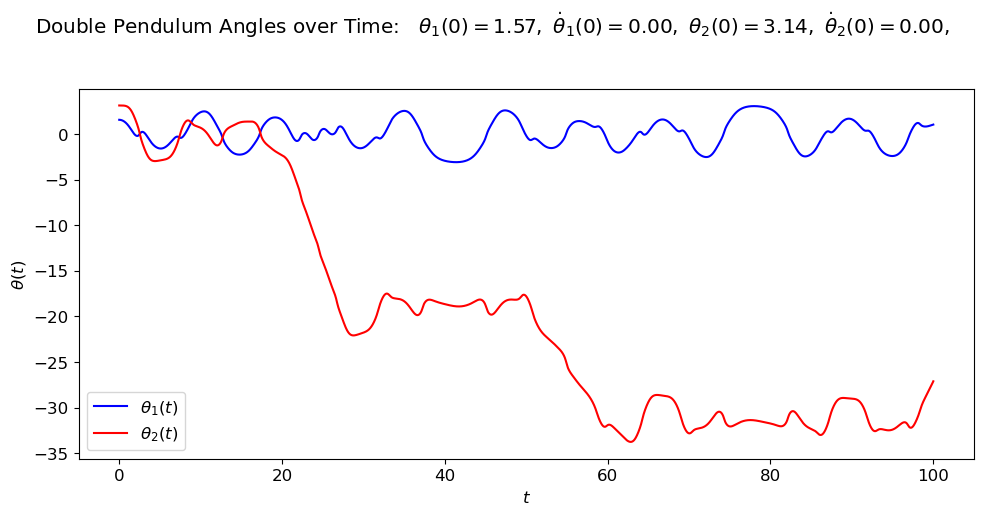

In [9]:
# both plots: same initial conditions
theta1_0 = np.pi/2.
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

theta1, theta1_dot, theta2, theta2_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)

fig = plt.figure(figsize=(10,5))
overall_title = 'Double Pendulum Angles over Time:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=r'$\theta_1(t)$', 
            ax=ax_a)    
                                  
plot_y_vs_x(t_pts[start : stop], theta2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red',
            label=r'$\theta_2(t)$', 
            ax=ax_a)    

fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

The above plot shows an increasing difference over time of the two angles. This could be indicative of chaotic motion, but the next plot is further confirmation.

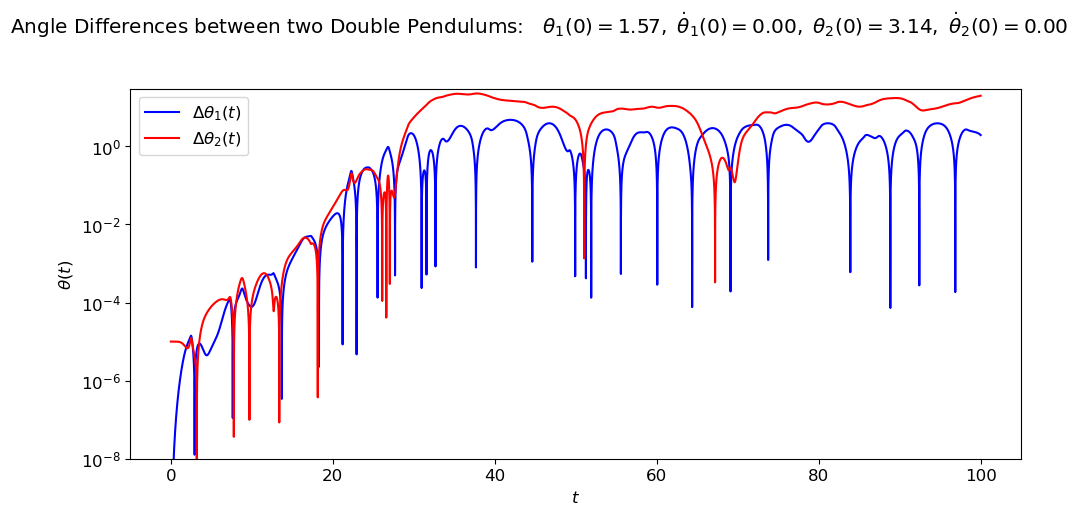

In [10]:

theta1_0 = np.pi/2.
theta1_dot_0 = 0.
theta2_0 = np.pi
theta2_dot_0 = 0.

theta1, theta1_dot, theta2, theta2_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1b_dot, theta2b, theta2b_dot = dp1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0-0.00001, theta2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Angle Differences between two Double Pendulums:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(theta1[start : stop]-theta1b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue', semilogy=True,
            label=r'$\Delta\theta_1(t)$', 
            ax=ax_a)    
                                  
plot_y_vs_x(t_pts[start : stop], np.abs(theta2[start : stop]-theta2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red', semilogy=True,
            label=r'$\Delta\theta_2(t)$', 
            ax=ax_a)    

ax_a.set_ylim(1.e-8,30)

fig.tight_layout()
fig.savefig('Double_pendulum_differences_final.png', bbox_inches='tight')  

This plot shows the differences between $\theta_1$,$\theta_{1b}$ and $\theta_2$,$\theta_{2b}$. The difference in initial conditions was very small: $\theta_{2b}$ was only changed by 0.00001, but the differences grow exponentially over time, as shown by the semilog plot. This sensitivity to initial conditions is indicative of chaotic motion.

## Double Pendulum Animation

In [11]:
from matplotlib import animation, rc
from IPython.display import HTML

In [12]:
def cartesian(x0, y0, theta, L):
    """
    Convert angles to cartesian coordinates for animation
    """
    x = x0 + L * np.sin(theta)
    y = y0 - L * np.cos(theta)
    return x, y

In [13]:
%%capture

x_min = -5.0
x_max = 5.0
y_min = -5.0
y_max = -y_min

fig_anim = plt.figure(figsize=(5,5), num='DoublePendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
x0, y0 = 0., 0.

pt0_anim, = ax_anim.plot(x0, y0, 'o', markersize=6, color='black')

x1, y1 = cartesian(x0, y0, theta1[0], dp1.L1)
pt1_anim, = ax_anim.plot(x1, y1, 'o', markersize=8, color='blue')
ln1_anim, = ax_anim.plot([x0, x1], [y0, y1], color='blue', lw=1)

x2, y2 = cartesian(x1, y1, theta2[0], dp1.L2)
pt2_anim, = ax_anim.plot(x2, y2, 'o', markersize=8, color='blue')
ln2_anim, = ax_anim.plot([x1, x2], [y1, y2], color='blue', lw=1)

x1b, y1b = cartesian(x0, y0, theta1b[0], dp1.L1)
pt1b_anim, = ax_anim.plot(x1b, y1b, 'o', markersize=8, color='red')
ln1b_anim, = ax_anim.plot([x0, x1b], [y0, y1b], color='red', lw=1)

x2b, y2b = cartesian(x1b, y1b, theta2b[0], dp1.L2)
pt2b_anim, = ax_anim.plot(x2b, y2b, 'o', markersize=8, color='red')
ln2b_anim, = ax_anim.plot([x1b, x2b], [y1b, y2b], color='red', lw=1)

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [14]:
def animate_pendulum(i):
    """
    FuncAnimation frame indexer
    """
    i_skip = 100 * i
    
    x0, y0 = 0., 0.
    pt0_anim.set_data(x0, y0)
    
    x1, y1 = cartesian(x0, y0, theta1[i_skip], dp1.L1)
    pt1_anim.set_data(x1, y1)
    ln1_anim.set_data([x0,x1],[y0,y1])
    x2, y2 = cartesian(x1, y1, theta2[i_skip], dp1.L2)
    pt2_anim.set_data(x2, y2)
    ln2_anim.set_data([x1,x2],[y1,y2])
    
    x1b, y1b = cartesian(x0, y0, theta1b[i_skip], dp1.L1)
    pt1b_anim.set_data(x1b, y1b)
    ln1b_anim.set_data([x0,x1b],[y0,y1b])
    x2b, y2b = cartesian(x1b, y1b, theta2b[i_skip], dp1.L2)
    pt2b_anim.set_data(x2b, y2b)
    ln2b_anim.set_data([x1b,x2b],[y1b,y2b])
    
    return(pt0_anim, pt1_anim, ln1_anim, pt2_anim, ln2_anim, pt1b_anim, ln1b_anim, pt2b_anim, ln2b_anim)



In [15]:
frame_interval = 20.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None, 
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True, 
                               repeat=False)

In [16]:
HTML(anim.to_jshtml())